In [1]:
# Imports
import pandas as pd
import datetime as dt

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

import tensorflow as tf
from keras.utils import to_categorical
from tensorflow.keras import layers, models, regularizers, callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from imblearn.over_sampling import SMOTE 

In [2]:
def clean_up_observations_and_add_rain_class(atg_obs_selected):
    no_erros_obs = atg_obs_selected.loc[(atg_obs_selected['Rain']!='M')&(atg_obs_selected['Temperature']!='M')&(atg_obs_selected['Pressure']!='M')&(atg_obs_selected['Relhum']!='M')&(atg_obs_selected['Relhum']!='0.00.')].copy()

    no_erros_obs['datetime_PST'] = pd.DatetimeIndex(no_erros_obs['datetime_UTC']).tz_localize('UTC').tz_convert('US/Pacific')
    no_erros_obs['Date_PST'] = pd.DatetimeIndex(no_erros_obs['datetime_PST']).date
    no_erros_obs['Time_PST'] = pd.DatetimeIndex(no_erros_obs['datetime_PST']).time
    no_erros_obs['Rain'] = no_erros_obs['Rain'].astype(float)
    no_erros_obs['Temperature'] = no_erros_obs['Temperature'].astype(float)
    no_erros_obs['Pressure'] = no_erros_obs['Pressure'].astype(float)
    no_erros_obs['Relhum'] = no_erros_obs['Relhum'].astype(float)

    first_obs_each_period = no_erros_obs.resample(on='datetime_UTC', rule='1h')
    summed_rain_each_period = first_obs_each_period['Rain'].sum()

    lightrainfall_times = summed_rain_each_period[(summed_rain_each_period<=0.08)&(summed_rain_each_period>0.0)]
    heavyrainfall_times = summed_rain_each_period[(summed_rain_each_period>0.08)]

    summed_rain_each_period.loc[lightrainfall_times.index] = 1
    summed_rain_each_period.loc[heavyrainfall_times.index] = 2

    # Extract Date, Time, Temperature, SumRain into data array
    atg_obs_necessary = pd.DataFrame()
    atg_obs_necessary['date'] = first_obs_each_period['Date_PST'].first()
    atg_obs_necessary['time'] = first_obs_each_period['Time_PST'].first()
    atg_obs_necessary['temperature'] = first_obs_each_period['Temperature'].first()
    atg_obs_necessary['pressure'] = first_obs_each_period['Pressure'].first()
    atg_obs_necessary['relhum'] = first_obs_each_period['Relhum'].first()
    atg_obs_necessary['rainfall_type'] = summed_rain_each_period

    atg_obs_necessary = atg_obs_necessary.dropna()
    data_arr = atg_obs_necessary.values

    return atg_obs_necessary, data_arr

In [3]:
atg_obs = pd.read_csv('../../Downloads/LFEM_data-.csv', low_memory=False, skiprows=1)
atg_obs.insert(0, 'datetime_UTC', pd.to_datetime(atg_obs['Date'] + atg_obs['Time'], format='%Y-%m-%d%H:%M'))

In [ ]:
atg_obs_selected = atg_obs.copy() # Selecting dates
atg_obs_selected = atg_obs_selected.loc[(atg_obs['datetime_UTC']>=dt.datetime(2022,5,1))]

In [ ]:
# Extract Date, Time, Temperature, SumRain into data array
atg_obs_necessary, data_arr = clean_up_observations_and_add_rain_class(atg_obs_selected)
atg_obs_necessary

,date,time,temperature,pressure,relhum,rainfall_type
datetime_UTC,,,,,,
2022-05-01 00:00:00,2022-04-30,17:00:00,60.7,1011.5,43.0,0.0
2022-05-01 00:30:00,2022-04-30,17:30:00,59.8,1011.8,47.5,0.0
2022-05-01 01:00:00,2022-04-30,18:00:00,59.6,1012.1,51.4,0.0
2022-05-01 01:30:00,2022-04-30,18:30:00,58.7,1012.3,55.4,0.0
2022-05-01 02:00:00,2022-04-30,19:00:00,58.1,1012.8,53.9,0.0
...,...,...,...,...,...,...
2024-05-23 15:30:00,2024-05-23,08:30:00,52.8,1017.1,67.8,0.0
2024-05-23 16:00:00,2024-05-23,09:00:00,53.2,1017.0,66.1,0.0
2024-05-23 16:30:00,2024-05-23,09:30:00,53.2,1017.1,65.3,0.0


In [ ]:
def select_times_around_specific_events(atg_obs_necessary, event, num_days_around):
    notable_event_times = atg_obs_necessary.loc[atg_obs_necessary['rainfall_type']>=event].index

    relevant_events = pd.DataFrame()
    for event_time in notable_event_times:
        start_time = event_time-pd.Timedelta(days=num_days_around)
        end_time = event_time+pd.Timedelta(days=num_days_around)
        time_around_event = atg_obs_necessary.loc[start_time:end_time].copy()
        relevant_events = pd.concat([relevant_events, time_around_event]).drop_duplicates()
    
    return relevant_events

In [ ]:
relevant_events = select_times_around_specific_events(atg_obs_necessary, 2, 30)
relevant_events

,date,time,temperature,pressure,relhum,rainfall_type
datetime_UTC,,,,,,
2022-05-01 00:00:00,2022-04-30,17:00:00,60.7,1011.5,43.0,0.0
2022-05-01 00:30:00,2022-04-30,17:30:00,59.8,1011.8,47.5,0.0
2022-05-01 01:00:00,2022-04-30,18:00:00,59.6,1012.1,51.4,0.0
2022-05-01 01:30:00,2022-04-30,18:30:00,58.7,1012.3,55.4,0.0
2022-05-01 02:00:00,2022-04-30,19:00:00,58.1,1012.8,53.9,0.0
...,...,...,...,...,...,...
2024-05-23 15:30:00,2024-05-23,08:30:00,52.8,1017.1,67.8,0.0
2024-05-23 16:00:00,2024-05-23,09:00:00,53.2,1017.0,66.1,0.0
2024-05-23 16:30:00,2024-05-23,09:30:00,53.2,1017.1,65.3,0.0


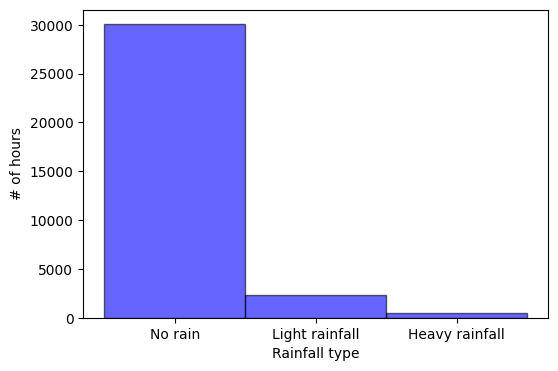

(array([30043,  2308,   517]), array([0., 1., 2., 3.]))

In [ ]:
rain_counts, classes = np.histogram(relevant_events['rainfall_type'].values, bins=np.arange(0,relevant_events['rainfall_type'].max()+2))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,relevant_events['rainfall_type'].max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xticks(ticks=np.arange(0,relevant_events['rainfall_type'].max()+1), labels=['No rain', 'Light rainfall', 'Heavy rainfall'])
plt.xlabel('Rainfall type')
plt.show()
rain_counts, classes

In [ ]:
def get_processed_df_from_data(dataset):
    date_objs = pd.to_datetime(dataset['date'], format="%Y-%m-%d")
    time_objs = pd.to_datetime(dataset['time'], format='%H:%M:%S')

    months = pd.DatetimeIndex(date_objs).month
    hours = pd.DatetimeIndex(time_objs).hour

    processed_df = pd.DataFrame()
    processed_df['month'] = months
    # processed_df['time_of_day'] = ((hours-4)%24) / 6

    vals = dataset['temperature']
    processed_df['feature_1'] = vals.values

    vals = dataset['relhum']
    processed_df['feature_2'] = vals.values

    vals = dataset['pressure']
    processed_df['feature_3'] = vals.values

    processed_df['class'] = dataset['rainfall_type'].values
    return processed_df

In [ ]:
def create_balancesampled_df(processed_df):
    two_samps = processed_df[processed_df['class']==2].copy()
    num_twos = two_samps.shape[0]

    dupl_processed_df = two_samps
    for group in np.arange(0, 2):
        under_group_samps = processed_df[processed_df['class']==group].copy()
        group_samps = under_group_samps.sample(n=(num_twos), replace=False, random_state=42)
        dupl_processed_df = pd.concat([dupl_processed_df, group_samps])
        
    return dupl_processed_df

def create_oversampled_df_from_raw(processed_df):
    num_zeros = processed_df[processed_df['rainfall_type']==0].shape[0]

    zeros_samps = processed_df[processed_df['rainfall_type']==0].copy()
    dupl_processed_df = zeros_samps
    for group in np.arange(1, 3):
        under_group_samps = processed_df[processed_df['rainfall_type']==group].copy()
        if len(under_group_samps)>0:
            group_samps = under_group_samps.sample(n=(num_zeros-len(under_group_samps)), replace=True, random_state=42)
            
            np.random.seed(1)
            noise = np.random.normal(0,1,(num_zeros-len(under_group_samps)))
            group_samps['temperature'] = group_samps['temperature']+noise

            np.random.seed(2)
            noise = np.random.normal(0,1,(num_zeros-len(under_group_samps)))
            group_samps['pressure'] = group_samps['pressure']+noise

            np.random.seed(3)
            noise = np.random.normal(0,1,(num_zeros-len(under_group_samps)))
            group_samps['relhum'] = group_samps['relhum']+noise

            dupl_processed_df = pd.concat([dupl_processed_df, under_group_samps, group_samps])

    return dupl_processed_df

def create_oversampled_df(processed_df):
    num_zeros = processed_df[processed_df['class']==0].shape[0]

    zeros_samps = processed_df[processed_df['class']==0].copy()
    dupl_processed_df = zeros_samps
    for group in np.arange(1, 3):
        under_group_samps = processed_df[processed_df['class']==group].copy()
        if len(under_group_samps)>0:
            group_samps = under_group_samps.sample(n=(num_zeros-len(under_group_samps)), replace=True, random_state=42)
            
            np.random.seed(1)
            noise = np.random.normal(0,1,(num_zeros-len(under_group_samps)))
            group_samps['feature_1'] = group_samps['feature_1']+noise

            np.random.seed(2)
            noise = np.random.normal(0,1,(num_zeros-len(under_group_samps)))
            group_samps['feature_2'] = group_samps['feature_2']+noise

            np.random.seed(3)
            noise = np.random.normal(0,1,(num_zeros-len(under_group_samps)))
            group_samps['feature_3'] = group_samps['feature_3']+noise

            dupl_processed_df = pd.concat([dupl_processed_df, under_group_samps, group_samps])

    return dupl_processed_df

In [ ]:
raw_df_train_val, raw_under_df_test = train_test_split(relevant_events,random_state=42,test_size=0.2)
raw_under_df_train, raw_under_df_val = train_test_split(raw_df_train_val,random_state=42,test_size=0.25)

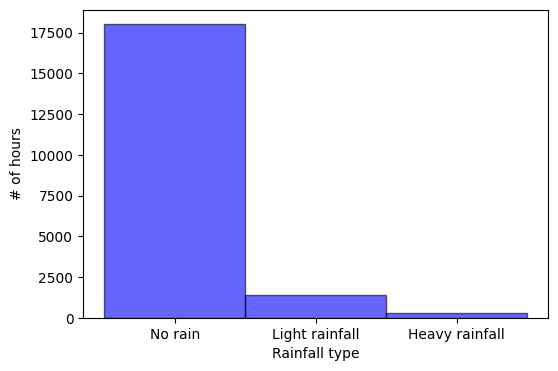

(array([18006,  1400,   314]), array([0., 1., 2., 3.]))

In [ ]:
under_sam_reltimes_tr = get_processed_df_from_data(raw_under_df_train)
rain_counts, classes = np.histogram(under_sam_reltimes_tr['class'].values, bins=np.arange(0,under_sam_reltimes_tr['class'].max()+2))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,under_sam_reltimes_tr['class'].max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xticks(ticks=np.arange(0,under_sam_reltimes_tr['class'].max()+1), labels=['No rain', 'Light rainfall', 'Heavy rainfall'])
plt.xlabel('Rainfall type')
plt.show()
rain_counts, classes

In [ ]:
raw_df_train = create_oversampled_df_from_raw(raw_under_df_train)
processed_df_train = create_oversampled_df(under_sam_reltimes_tr)
processed_df_train

,month,feature_1,feature_2,feature_3,class
0,4,53.000000,64.700000,1008.300000,0.0
1,9,67.200000,67.000000,1009.100000,0.0
2,3,46.800000,75.500000,1008.400000,0.0
3,3,40.400000,80.000000,1030.000000,0.0
4,7,73.500000,53.400000,1012.800000,0.0
...,...,...,...,...,...
18709,11,36.281828,92.369689,996.716409,2.0
10507,12,42.000766,97.557710,1012.173223,2.0
363,12,42.276205,96.197368,1012.514545,2.0
11767,4,43.322948,86.037645,1000.543863,2.0


In [ ]:
train_data_sorted_may = raw_df_train.loc[(processed_df_train['month']==5).values, :].sort_index()
train_data_sorted_may

,date,time,temperature,pressure,relhum,rainfall_type
datetime_UTC,,,,,,
2022-05-01 07:00:00,2022-05-01,00:00:00,51.5,1014.7,71.0,0.0
2022-05-01 08:30:00,2022-05-01,01:30:00,49.6,1015.6,76.6,0.0
2022-05-01 09:00:00,2022-05-01,02:00:00,48.7,1015.5,79.6,0.0
2022-05-01 09:30:00,2022-05-01,02:30:00,48.6,1015.4,81.0,0.0
2022-05-01 10:30:00,2022-05-01,03:30:00,47.9,1015.6,83.1,0.0
...,...,...,...,...,...,...
2024-05-23 15:00:00,2024-05-23,08:00:00,52.4,1017.0,69.1,0.0
2024-05-23 15:30:00,2024-05-23,08:30:00,52.8,1017.1,67.8,0.0
2024-05-23 16:00:00,2024-05-23,09:00:00,53.2,1017.0,66.1,0.0


In [ ]:
train_data_sorted_may[train_data_sorted_may['rainfall_type']==2]

,date,time,temperature,pressure,relhum,rainfall_type
datetime_UTC,,,,,,
2022-05-02 14:00:00,2022-05-02,07:00:00,46.704353,1003.206811,84.193104,2.0
2022-05-02 14:00:00,2022-05-02,07:00:00,46.658532,1005.232735,85.801313,2.0
2022-05-02 14:00:00,2022-05-02,07:00:00,47.947472,1004.365780,84.102291,2.0
2022-05-02 14:00:00,2022-05-02,07:00:00,47.898112,1004.885618,84.482569,2.0
2022-05-02 14:00:00,2022-05-02,07:00:00,47.052774,1006.123224,85.257783,2.0
...,...,...,...,...,...,...
2024-05-22 11:00:00,2024-05-22,04:00:00,46.714020,1006.397392,89.063295,2.0
2024-05-22 11:00:00,2024-05-22,04:00:00,45.256637,1009.249383,88.695157,2.0
2024-05-22 11:00:00,2024-05-22,04:00:00,46.549680,1006.789129,88.365333,2.0


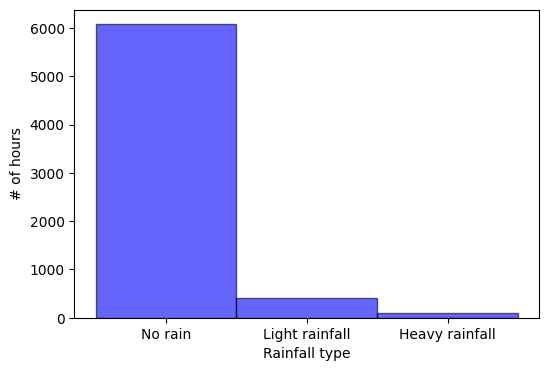

(array([6073,  410,   91]), array([0., 1., 2., 3.]))

In [ ]:
processed_df_val = get_processed_df_from_data(raw_under_df_val)
rain_counts, classes = np.histogram(processed_df_val['class'].values, bins=np.arange(0,processed_df_val['class'].max()+2))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,processed_df_val['class'].max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xticks(ticks=np.arange(0,processed_df_val['class'].max()+1), labels=['No rain', 'Light rainfall', 'Heavy rainfall'])
plt.xlabel('Rainfall type')
plt.show()
rain_counts, classes

In [ ]:
processed_df_train.shape, processed_df_val.shape

((54018, 5), (6574, 5))

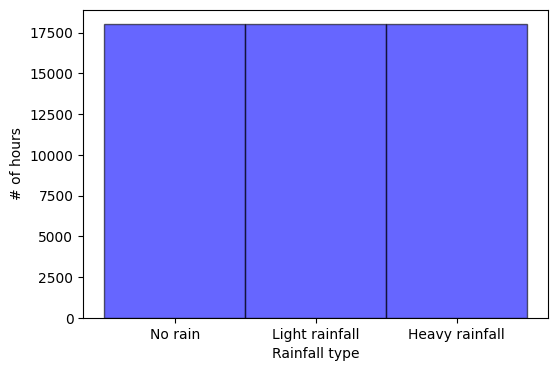

(array([18006, 18006, 18006]), array([0., 1., 2., 3.]))

In [ ]:
rain_counts, classes = np.histogram(processed_df_train['class'].values, bins=np.arange(0,processed_df_train['class'].max()+2))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,processed_df_train['class'].max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.xticks(ticks=np.arange(0,processed_df_train['class'].max()+1), labels=['No rain', 'Light rainfall', 'Heavy rainfall'])
plt.xlabel('Rainfall type')
plt.ylabel('# of hours')
plt.show()
rain_counts, classes

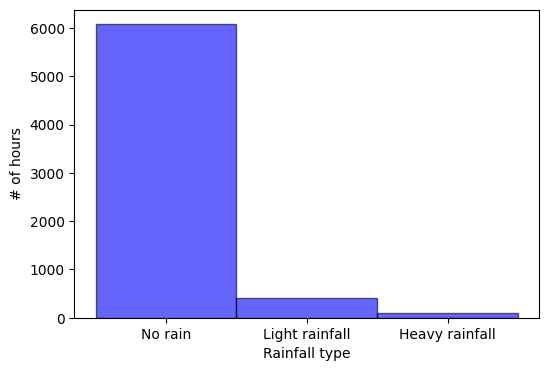

(array([6073,  410,   91]), array([0., 1., 2., 3.]))

In [ ]:
rain_counts, classes = np.histogram(processed_df_val['class'].values, bins=np.arange(0,processed_df_train['class'].max()+2))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,processed_df_train['class'].max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.xticks(ticks=np.arange(0,processed_df_train['class'].max()+1), labels=['No rain', 'Light rainfall', 'Heavy rainfall'])
plt.xlabel('Rainfall type')
plt.ylabel('# of hours')
plt.show()
rain_counts, classes

In [ ]:
processed_data_train = processed_df_train.values.astype(float)
processed_data_train.shape

(54018, 5)

In [ ]:
processed_data_val = processed_df_val.values.astype(float)
processed_data_val.shape

(6574, 5)

In [ ]:
x_data_train = processed_data_train[:, :processed_data_train.shape[1]-1]
y_train_labs = processed_data_train[:, processed_data_train.shape[1]-1:]
y_data_train = to_categorical(y_train_labs, 3)
print(x_data_train[0], y_data_train[0])

[   4.    53.    64.7 1008.3] [1. 0. 0.]


In [ ]:
x_data_val = processed_data_val[:, :processed_data_val.shape[1]-1]
y_val_labs = processed_data_val[:, processed_data_val.shape[1]-1:]
y_data_val = to_categorical(y_val_labs, 3)
print(x_data_val[0], y_data_val[0])

[   9.    59.9   84.2 1005.5] [0. 0. 1.]


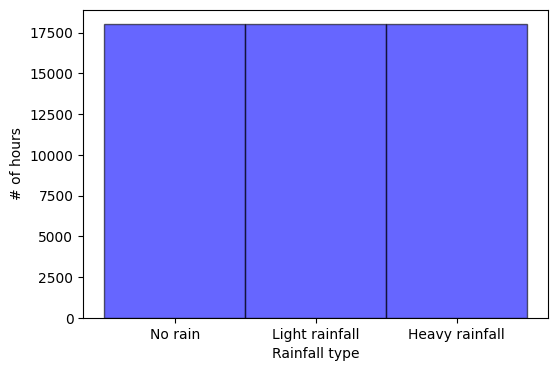

(array([18006, 18006, 18006]), array([0., 1., 2., 3.]))

In [ ]:
rain_counts, classes = np.histogram(y_train_labs, bins=np.arange(0,y_train_labs.max()+2))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,y_train_labs.max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xticks(ticks=np.arange(0,y_train_labs.max()+1), labels=['No rain', 'Light rainfall', 'Heavy rainfall'])
plt.xlabel('Rainfall type')
plt.show()
rain_counts, classes

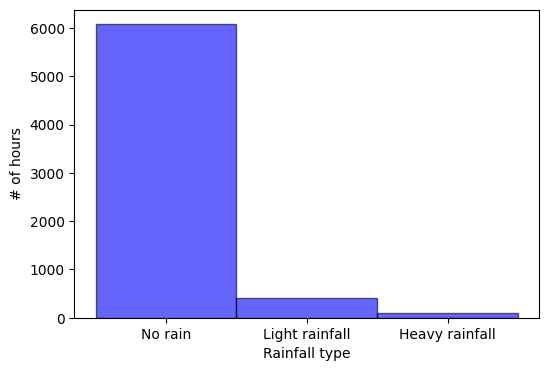

(array([6073,  410,   91]), array([0., 1., 2., 3.]))

In [ ]:
rain_counts, classes = np.histogram(y_val_labs, bins=np.arange(0,y_val_labs.max()+2))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,y_val_labs.max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xticks(ticks=np.arange(0,y_val_labs.max()+1), labels=['No rain', 'Light rainfall', 'Heavy rainfall'])
plt.xlabel('Rainfall type')
plt.show()
rain_counts, classes

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_data_train)
X_val_scaled = scaler.transform(x_data_val)

# Define the model
model = models.Sequential()

# Input layer
model.add(layers.Input(shape=(x_data_train.shape[1],)))

# Hidden layers
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))

# Output layer
model.add(layers.Dense(3, activation='softmax'))  # Softmax for multiclass classification

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Learning rate reduction callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Early stopping callback
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Print model summary
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 128)               640       
                                                                 
 dense_29 (Dense)            (None, 128)               16512     
                                                                 
 dense_30 (Dense)            (None, 64)                8256      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_31 (Dense)            (None, 3)                 195       
                                                                 
Total params: 25,603
Trainable params: 25,603
Non-trainable params: 0
_________________________________________________________________


In [ ]:
X_train_scaled.shape, y_data_train.shape

((54018, 4), (54018, 3))

In [ ]:
X_val_scaled.shape, y_data_val.shape

((6574, 4), (6574, 3))

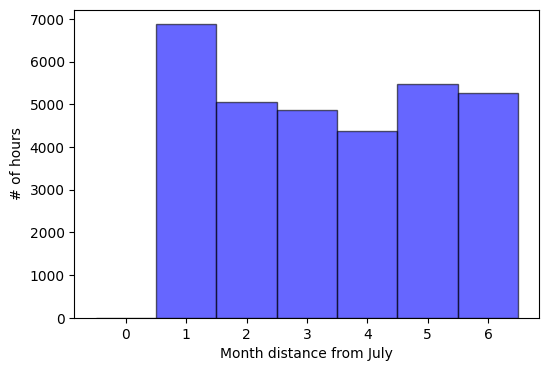

(array([   0, 6871, 5043, 4857, 4366, 5470, 5268]),
 array([0, 1, 2, 3, 4, 5, 6, 7]))

In [ ]:
binwidth = 1
rain_counts, classes = np.histogram(x_data_train[:,0], bins=np.arange(0,7+binwidth,binwidth))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,7,binwidth), width=binwidth, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xlabel('Month distance from July')
plt.show()
rain_counts, classes

In [ ]:
X_train_scaled

array([[-0.61458615,  0.30832373, -1.09401515, -0.043516  ],
       [ 0.64081055,  1.82985555, -0.94189702,  0.0522416 ],
       [-0.86566549, -0.35600706, -0.37972131, -0.0315463 ],
       ...,
       [ 1.39404856, -0.84073227,  0.98916779,  0.46095244],
       [-0.61458615, -0.72857358,  0.31722083, -0.97190237],
       [-1.11674482, -1.09961467,  0.31700825, -0.51145125]])

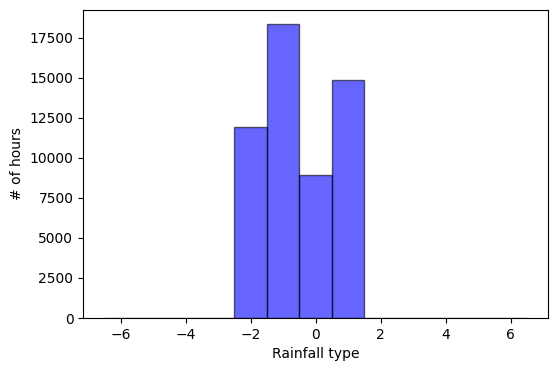

(array([    0,     0,     0,     0, 11914, 18324,  8927, 14853,     0,
            0,     0,     0,     0]),
 array([-6, -5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7]))

In [ ]:
binwidth = 1
rain_counts, classes = np.histogram(X_train_scaled[:,0], bins=np.arange(-6,7+binwidth,binwidth))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(-6,7,binwidth), width=binwidth, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xlabel('Rainfall type')
plt.show()
rain_counts, classes

In [ ]:
scaler.mean_, scaler.scale_

(array([   6.44777667,   50.1225071 ,   81.24132092, 1008.66355129]),
 array([ 3.98280482,  9.33270002, 15.11982799,  8.3544278 ]))

In [ ]:
# Train the Model:
history = model.fit(
    X_train_scaled, y_data_train,
    epochs=40,
    batch_size=32,
    validation_data=(X_val_scaled, y_data_val),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/40


2024-06-01 23:32:31.349042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1689/1689 [==============================] - ETA: 0s - loss: 0.8568 - accuracy: 0.6299

2024-06-01 23:32:54.713402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1689/1689 [==============================] - 26s 15ms/step - loss: 0.8568 - accuracy: 0.6299 - val_loss: 0.6083 - val_accuracy: 0.7890 - lr: 0.0010
Epoch 2/40
1689/1689 [==============================] - 25s 15ms/step - loss: 0.7925 - accuracy: 0.6388 - val_loss: 0.6489 - val_accuracy: 0.7682 - lr: 0.0010
Epoch 3/40
1689/1689 [==============================] - 25s 15ms/step - loss: 0.7805 - accuracy: 0.6440 - val_loss: 0.6367 - val_accuracy: 0.7694 - lr: 0.0010
Epoch 4/40
1689/1689 [==============================] - 24s 14ms/step - loss: 0.7713 - accuracy: 0.6482 - val_loss: 0.6317 - val_accuracy: 0.7618 - lr: 0.0010
Epoch 5/40
1689/1689 [==============================] - 24s 14ms/step - loss: 0.7646 - accuracy: 0.6527 - val_loss: 0.6195 - val_accuracy: 0.7496 - lr: 0.0010
Epoch 6/40
1689/1689 [==============================] - 24s 14ms/step - loss: 0.7592 - accuracy: 0.6582 - val_loss: 0.6124 - val_accuracy: 0.7531 - lr: 0.0010
Epoch 7/40
1689/1689 [==============================] - 2

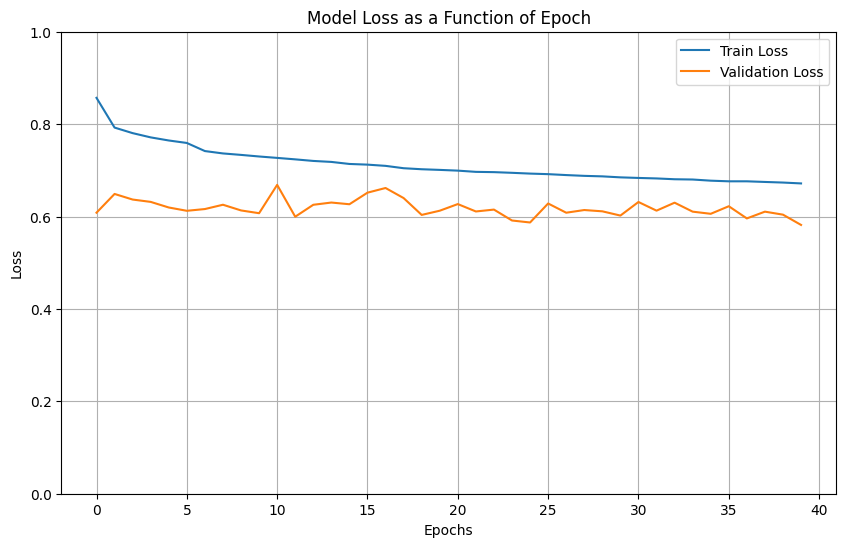

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the accuracy
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.title('Model Loss as a Function of Epoch')
plt.legend()
plt.grid(True)
plt.show()

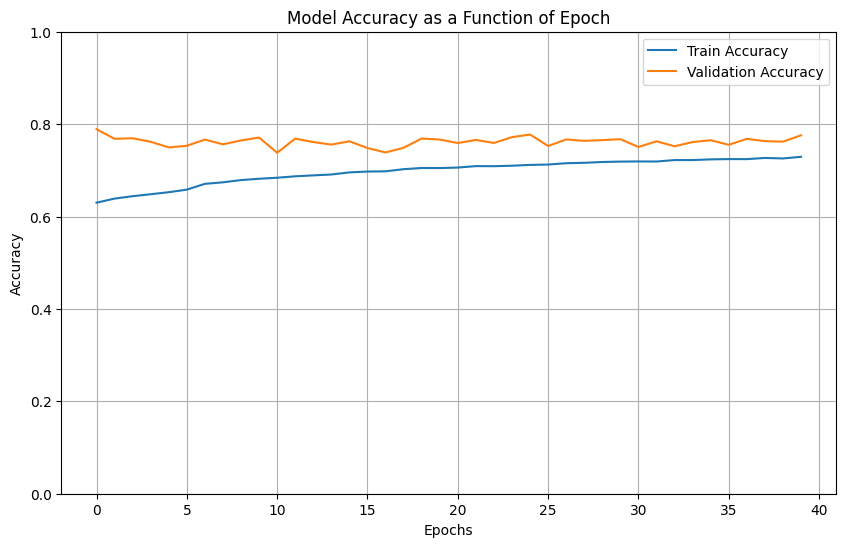

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot the accuracy
plt.figure(figsize=(10, 6))
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.title('Model Accuracy as a Function of Epoch')
plt.legend()
plt.grid(True)
plt.show()

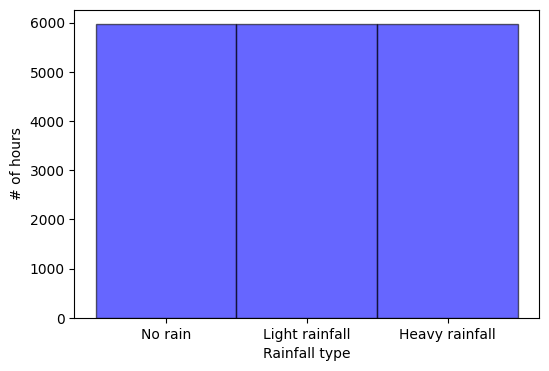

[5964 5964 5964] [0. 1. 2. 3.]
[   5.    90.9   21.4 1010.3] [1. 0. 0.]


In [ ]:
under_sam_reltimes_te = get_processed_df_from_data(raw_under_df_test)
processed_df_test = create_oversampled_df(under_sam_reltimes_te)

rain_counts, classes = np.histogram(processed_df_test['class'].values, bins=np.arange(0,processed_df_train['class'].max()+2))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,processed_df_train['class'].max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.xticks(ticks=np.arange(0,processed_df_train['class'].max()+1), labels=['No rain', 'Light rainfall', 'Heavy rainfall'])
plt.xlabel('Rainfall type')
plt.ylabel('# of hours')
plt.show()
print(rain_counts, classes)

processed_data_test = processed_df_test.values.astype(float)
x_data_test = processed_data_test[:, :processed_data_test.shape[1]-1]
y_test_labs = processed_data_test[:, processed_data_test.shape[1]-1:]
y_data_test = to_categorical(y_test_labs, 3)
print(x_data_test[0], y_data_test[0])

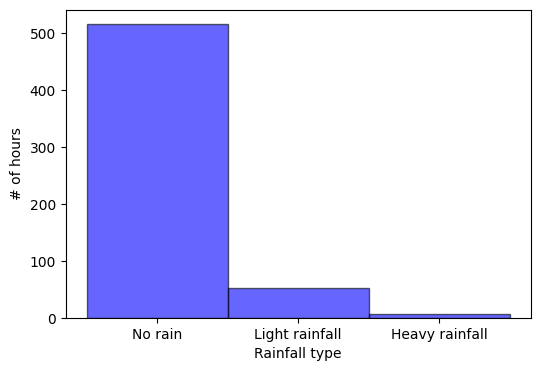

[515  52   7] [0. 1. 2. 3.]


In [ ]:
test_data_sorted_month = raw_under_df_test.loc[(under_sam_reltimes_te['month']==2).values, :].sort_index()

rain_counts, classes = np.histogram(test_data_sorted_month['rainfall_type'].values, bins=np.arange(0,test_data_sorted_month['rainfall_type'].max()+2))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,test_data_sorted_month['rainfall_type'].max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.xticks(ticks=np.arange(0,test_data_sorted_month['rainfall_type'].max()+1), labels=['No rain', 'Light rainfall', 'Heavy rainfall'])
plt.xlabel('Rainfall type')
plt.ylabel('# of hours')
plt.show()
print(rain_counts, classes)

In [ ]:
test_data_sorted_month

,date,time,temperature,pressure,relhum,rainfall_type
datetime_UTC,,,,,,
2023-02-01 08:00:00,2023-02-01,00:00:00,40.2,1017.9,71.5,0.0
2023-02-01 14:30:00,2023-02-01,06:30:00,38.6,1017.1,56.0,0.0
2023-02-01 16:30:00,2023-02-01,08:30:00,38.5,1017.4,68.7,0.0
2023-02-01 17:00:00,2023-02-01,09:00:00,39.0,1017.3,65.7,0.0
2023-02-01 17:30:00,2023-02-01,09:30:00,38.9,1017.4,72.4,0.0
...,...,...,...,...,...,...
2024-02-29 23:00:00,2024-02-29,15:00:00,42.6,994.1,75.1,0.0
2024-03-01 00:00:00,2024-02-29,16:00:00,42.4,994.4,75.0,0.0
2024-03-01 01:00:00,2024-02-29,17:00:00,39.6,994.9,78.2,0.0


In [ ]:
processed_test_sorted_month_balanced_raw = create_oversampled_df_from_raw(test_data_sorted_month).sort_index()
processed_test_sorted_month_balanced_raw

,date,time,temperature,pressure,relhum,rainfall_type
datetime_UTC,,,,,,
2023-02-01 08:00:00,2023-02-01,00:00:00,40.2,1017.9,71.5,0.0
2023-02-01 14:30:00,2023-02-01,06:30:00,38.6,1017.1,56.0,0.0
2023-02-01 16:30:00,2023-02-01,08:30:00,38.5,1017.4,68.7,0.0
2023-02-01 17:00:00,2023-02-01,09:00:00,39.0,1017.3,65.7,0.0
2023-02-01 17:30:00,2023-02-01,09:30:00,38.9,1017.4,72.4,0.0
...,...,...,...,...,...,...
2024-02-29 23:00:00,2024-02-29,15:00:00,42.6,994.1,75.1,0.0
2024-03-01 00:00:00,2024-02-29,16:00:00,42.4,994.4,75.0,0.0
2024-03-01 01:00:00,2024-02-29,17:00:00,39.6,994.9,78.2,0.0


In [ ]:
processed_test_sorted_month = get_processed_df_from_data(processed_test_sorted_month_balanced_raw)
processed_test_sorted_month

,month,feature_1,feature_2,feature_3,class
0,2,40.2,71.5,1017.9,0.0
1,2,38.6,56.0,1017.1,0.0
2,2,38.5,68.7,1017.4,0.0
3,2,39.0,65.7,1017.3,0.0
4,2,38.9,72.4,1017.4,0.0
...,...,...,...,...,...
1540,2,42.6,75.1,994.1,0.0
1541,2,42.4,75.0,994.4,0.0
1542,2,39.6,78.2,994.9,0.0
1543,2,37.3,93.3,994.8,0.0


In [ ]:
test_data_sorted_month[test_data_sorted_month['rainfall_type']==2]

,date,time,temperature,pressure,relhum,rainfall_type
datetime_UTC,,,,,,
2023-02-26 12:00:00,2023-02-26,04:00:00,33.1,992.8,98.2,2.0
2024-02-12 02:30:00,2024-02-11,18:30:00,48.6,1012.9,92.1,2.0
2024-02-21 22:00:00,2024-02-21,14:00:00,48.7,1011.2,91.6,2.0
2024-02-28 22:30:00,2024-02-28,14:30:00,50.4,997.5,85.8,2.0
2024-02-29 00:00:00,2024-02-28,16:00:00,49.8,996.1,89.2,2.0
2024-02-29 01:00:00,2024-02-28,17:00:00,49.3,995.2,92.3,2.0
2024-02-29 01:30:00,2024-02-28,17:30:00,49.3,994.9,90.9,2.0


In [ ]:
processed_data_test_month = processed_test_sorted_month.values.astype(float)
x_data_test_month = processed_data_test_month[:, :processed_data_test_month.shape[1]-1]
y_test_labs_month = processed_data_test_month[:, processed_data_test_month.shape[1]-1:]
y_data_test_month = to_categorical(y_test_labs_month, 3)
print(x_data_test_month[0], y_data_test_month[0])

[   2.    40.2   71.5 1017.9] [1. 0. 0.]


In [ ]:
X_test_scaled_month = scaler.transform(x_data_test_month)
predictions_month = model.predict(X_test_scaled_month)

49/49 [==============================] - 0s 3ms/step


2024-06-01 23:49:20.419640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [ ]:
np.argmax(y_data_test_month, axis=1)

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
np.argmax(predictions_month,axis=1)

array([0, 0, 0, ..., 0, 1, 1])

In [ ]:
processed_test_sorted_month['predictions'] = np.argmax(predictions_month,axis=1)
processed_test_sorted_month

,month,feature_1,feature_2,feature_3,class,predictions
0,2,40.2,71.5,1017.9,0.0,0
1,2,38.6,56.0,1017.1,0.0,0
2,2,38.5,68.7,1017.4,0.0,0
3,2,39.0,65.7,1017.3,0.0,0
4,2,38.9,72.4,1017.4,0.0,0
...,...,...,...,...,...,...
1540,2,42.6,75.1,994.1,0.0,0
1541,2,42.4,75.0,994.4,0.0,0
1542,2,39.6,78.2,994.9,0.0,0
1543,2,37.3,93.3,994.8,0.0,1


In [ ]:
processed_test_sorted_month[processed_test_sorted_month['class']>=1]

,month,feature_1,feature_2,feature_3,class,predictions
27,2,49.529465,71.183974,1011.379745,1.0,0
28,2,49.740556,71.369418,1009.935333,1.0,0
29,2,50.224508,70.606463,1008.486078,1.0,0
30,2,50.111057,72.148168,1007.392579,1.0,0
31,2,47.766879,72.151995,1007.651825,1.0,0
...,...,...,...,...,...,...
1529,2,47.488779,88.544467,989.789501,1.0,2
1530,2,45.377608,89.656222,991.771622,1.0,2
1531,2,44.673445,89.358156,993.230947,1.0,2
1532,2,47.643359,88.527624,990.724338,1.0,2


Confusion Matrix:
[[317 155  43]
 [ 99 349  67]
 [  0 254 261]]


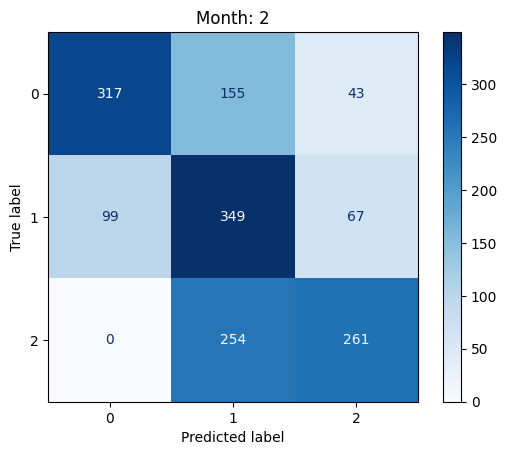

In [ ]:
cm = confusion_matrix(np.argmax(y_data_test_month, axis=1), np.argmax(predictions_month,axis=1))

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Month: {2}')
plt.show()

45/45 [==============================] - 0s 3ms/step


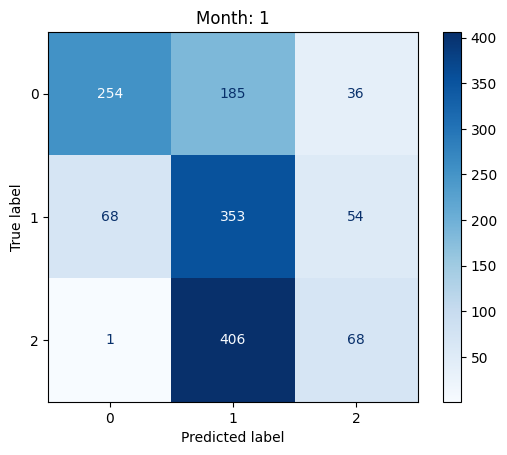

49/49 [==============================] - 0s 3ms/step


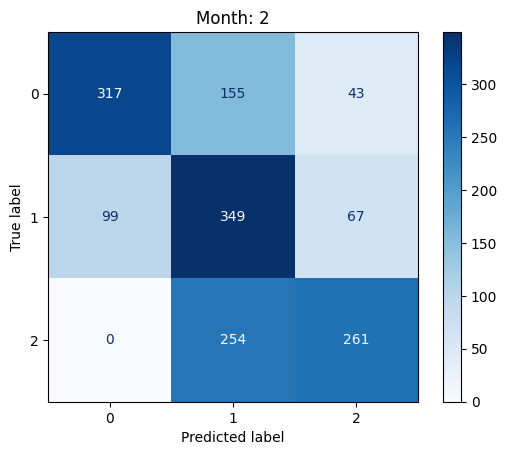

51/51 [==============================] - 0s 3ms/step


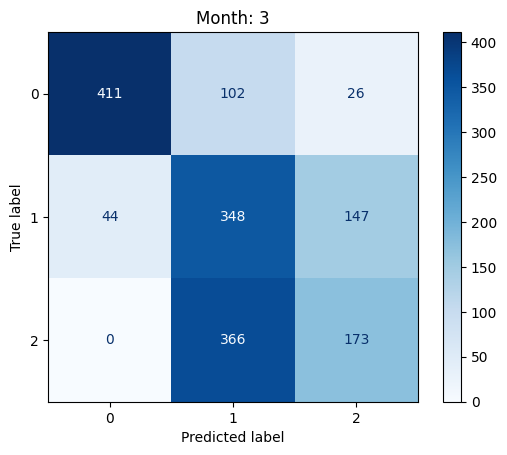

47/47 [==============================] - 0s 3ms/step


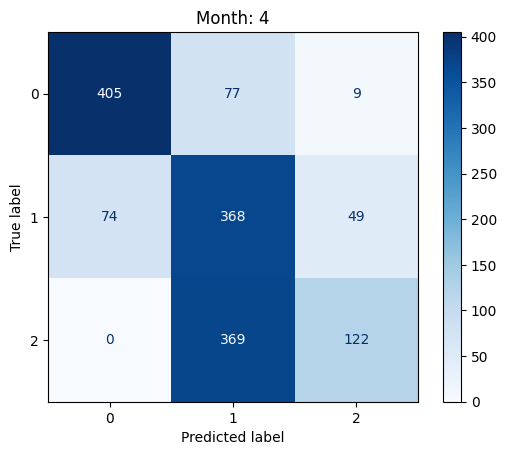

72/72 [==============================] - 0s 3ms/step


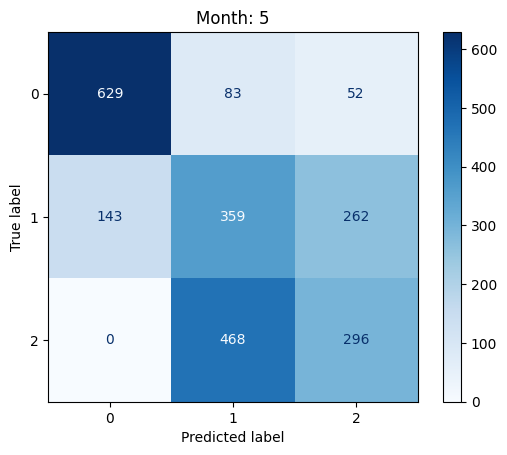

49/49 [==============================] - 0s 3ms/step


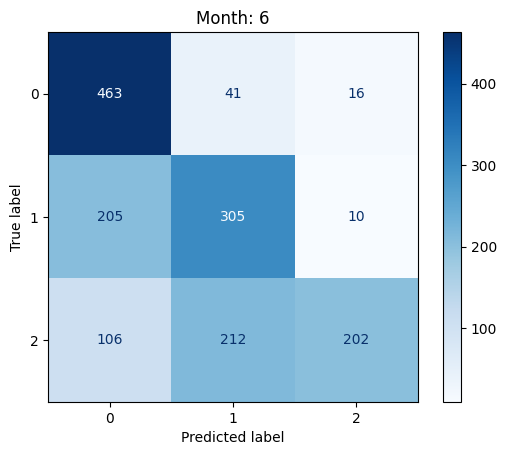

30/30 [==============================] - 0s 3ms/step


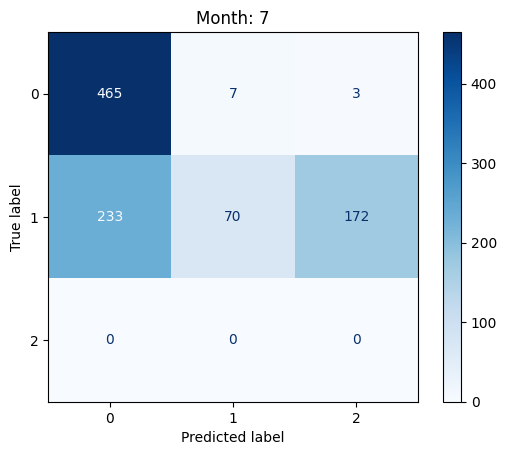

49/49 [==============================] - 0s 3ms/step


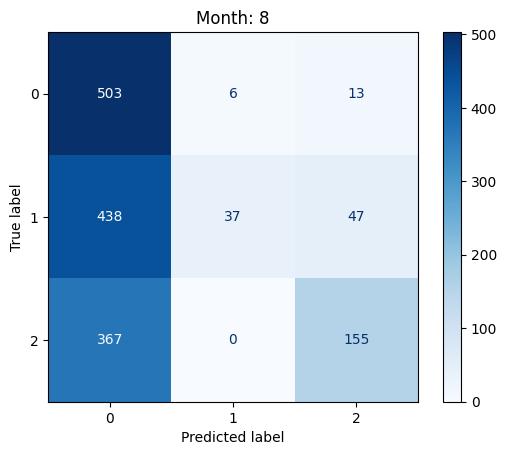

51/51 [==============================] - 0s 3ms/step


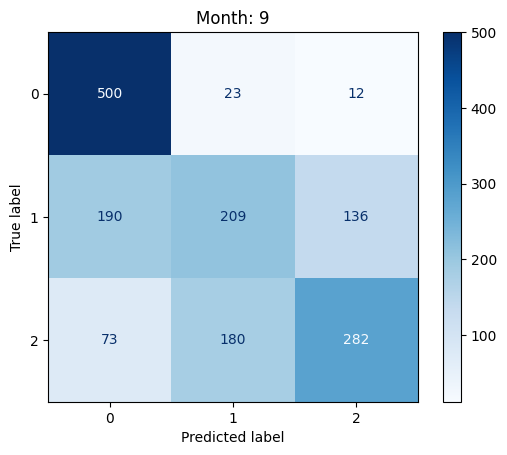

27/27 [==============================] - 0s 7ms/step


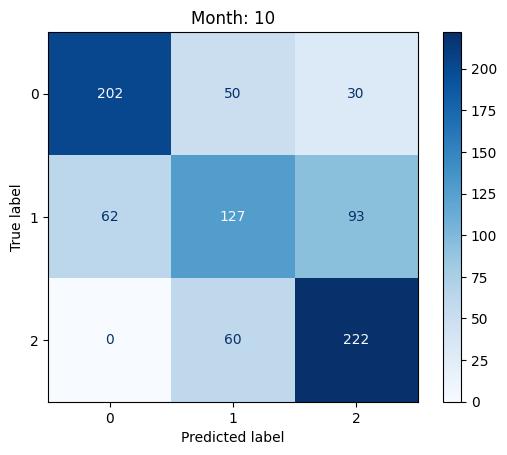

32/32 [==============================] - 0s 3ms/step


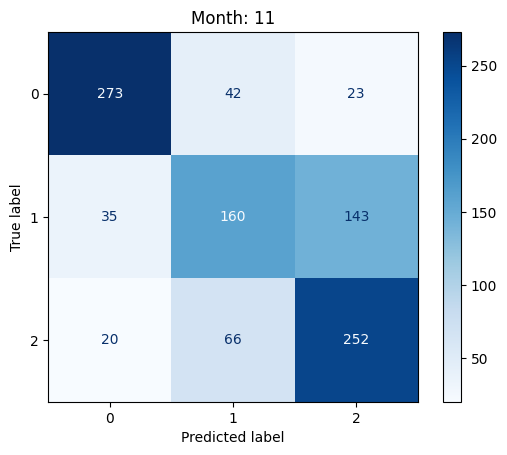

48/48 [==============================] - 0s 3ms/step


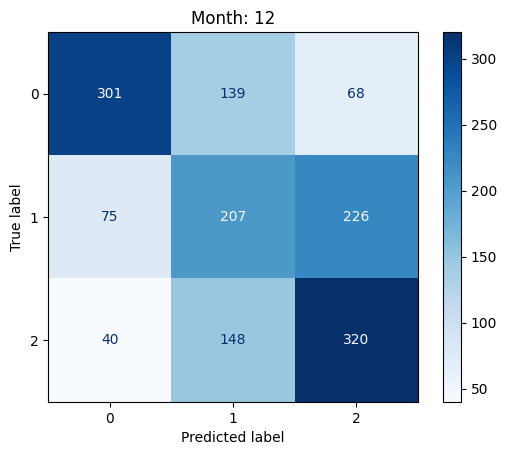

In [ ]:
for month_num in np.arange(1, 13):
    test_data_sorted_month = raw_under_df_test.loc[(under_sam_reltimes_te['month']==month_num).values, :].sort_index()
    processed_test_sorted_month_balanced_raw = create_oversampled_df_from_raw(test_data_sorted_month).sort_index()
    processed_test_sorted_month = get_processed_df_from_data(processed_test_sorted_month_balanced_raw)
    processed_data_test_month = processed_test_sorted_month.values.astype(float)
    x_data_test_month = processed_data_test_month[:, :processed_data_test_month.shape[1]-1]
    y_test_labs_month = processed_data_test_month[:, processed_data_test_month.shape[1]-1:]
    y_data_test_month = to_categorical(y_test_labs_month, 3)

    X_test_scaled_month = scaler.transform(x_data_test_month)
    predictions_month = model.predict(X_test_scaled_month)

    cm = confusion_matrix(np.argmax(y_data_test_month, axis=1), np.argmax(predictions_month,axis=1))

    # Visualize the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Month: {month_num}')
    plt.show()

In [ ]:
f1_score(np.argmax(y_data_test_month, axis=1), np.argmax(predictions_month,axis=1), average=None)

array([0.65151515, 0.41317365, 0.57040998])

In [ ]:
scaler.mean_, scaler.scale_

(array([   6.44777667,   50.1225071 ,   81.24132092, 1008.66355129]),
 array([ 3.98280482,  9.33270002, 15.11982799,  8.3544278 ]))

In [ ]:
X_test_scaled = scaler.transform(x_data_test)
predictions = model.predict(X_test_scaled)
model.evaluate(X_test_scaled, y_data_test, verbose=2)

560/560 [==============================] - 1s 2ms/step
560/560 - 5s - loss: 0.8364 - accuracy: 0.6276 - 5s/epoch - 9ms/step


[0.8363504409790039, 0.6275989413261414]

Confusion Matrix:
[[4723  910  331]
 [1017 3437 1510]
 [ 375 2520 3069]]


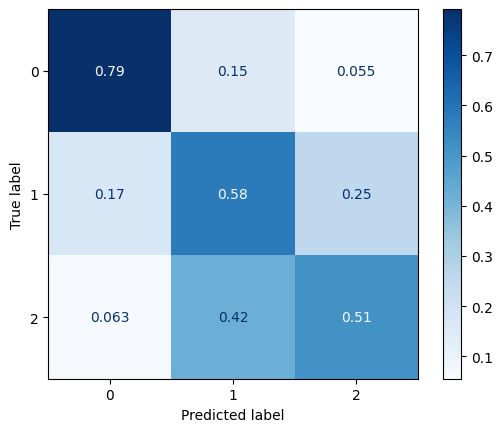

In [ ]:
cm = confusion_matrix(np.argmax(y_data_test, axis=1), np.argmax(predictions,axis=1))

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=(cm / np.sum(cm, axis=1).reshape(3, 1)), display_labels=[0, 1, 2])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
f1_score(np.argmax(y_data_test, axis=1), np.argmax(predictions,axis=1), average=None)

array([0.78201838, 0.53573377, 0.5644657 ])

In [ ]:
# Assuming you have already trained your model
model.save('../models/3class_weather_for30.h5')

In [ ]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("../models/3class_weather_for30.tflite", "wb").write(tflite_model)

import os
basic_model_size = os.path.getsize("../models/3class_weather_for30.tflite")
print("Model is %d bytes" % basic_model_size)

INFO:tensorflow:Assets written to: /var/folders/qj/4txkrxcn2ld7mby9_6n6npnr0000gn/T/tmpbnwm_cec/assets
Model is 104912 bytes


2024-06-01 22:49:00.813955: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2024-06-01 22:49:00.813972: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2024-06-01 22:49:00.815261: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/qj/4txkrxcn2ld7mby9_6n6npnr0000gn/T/tmpbnwm_cec
2024-06-01 22:49:00.817401: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2024-06-01 22:49:00.817411: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /var/folders/qj/4txkrxcn2ld7mby9_6n6npnr0000gn/T/tmpbnwm_cec
2024-06-01 22:49:00.822072: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2024-06-01 22:49:00.823485: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2024-06-01 22:49:00.880189: I tensorflow/cc/saved_model/loader.

In [ ]:
!echo "const unsigned char model[] = {" > ../arduino/3class_model_for30.h
!cat ../models/3class_weather_for30.tflite | xxd -i      >> ../arduino/3class_model_for30.h
!echo "};"                              >> ../arduino/3class_model_for30.h

In [ ]:
import os
model_h_size = os.path.getsize("../arduino/3class_model_for30.h")
print(f"Header file, 3class_model_for30.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click 3class_model_for30.h to download the file.")

Header file, 3class_model_for30.h, is 646,992 bytes.

Open the side panel (refresh if needed). Double click 3class_model_for30.h to download the file.


In [ ]:
# Load the TFLite model
tflite_model_path = '../models/3class_weather_for30.tflite'
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)

# Allocate tensors
interpreter.allocate_tensors()

# Get input and output tensor details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Print the original expected input shape
print("Original expected input shape:", input_details[0]['shape'])

batch_input_data = X_test_scaled.astype(np.float32)

# Modify the input tensor shape to accommodate the batch size
interpreter.resize_tensor_input(input_details[0]['index'], [batch_input_data.shape[0], batch_input_data.shape[1]])
interpreter.allocate_tensors()  # Reallocate tensors with the new input shape

# Verify the new input shape
input_details = interpreter.get_input_details()
print("New expected input shape:", input_details[0]['shape'])

# Set the input tensor
interpreter.set_tensor(input_details[0]['index'], batch_input_data)
# Run the inference
interpreter.invoke()

# Get the output tensor
tflite_predicitons = interpreter.get_tensor(output_details[0]['index'])
print("Predictions:", tflite_predicitons)

Original expected input shape: [1 4]
New expected input shape: [10227     4]
Predictions: [[6.08064532e-01 3.66285473e-01 2.56500281e-02]
 [9.10785854e-01 8.92104879e-02 3.72536419e-06]
 [9.99122798e-01 8.77193641e-04 3.26271860e-13]
 ...
 [4.67488430e-02 2.28925914e-01 7.24325299e-01]
 [1.85017005e-01 6.39615297e-01 1.75367683e-01]
 [8.93901229e-01 1.05767205e-01 3.31479358e-04]]


Confusion Matrix:
[[2605  562  242]
 [ 453 1851 1105]
 [ 348 1338 1723]]


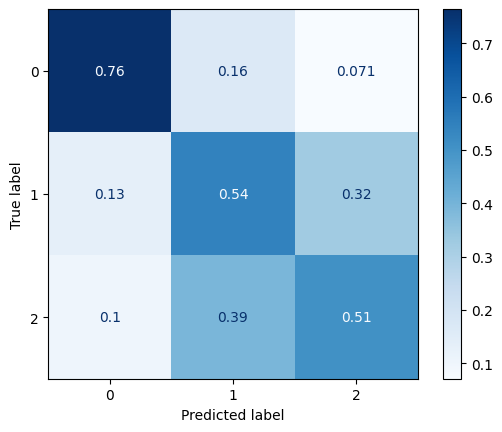

In [ ]:
cm = confusion_matrix(np.argmax(y_data_test, axis=1), np.argmax(tflite_predicitons,axis=1))

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=(cm / np.sum(cm, axis=1).reshape(3, 1)), display_labels=[0, 1, 2])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
f1_score(np.argmax(y_data_test, axis=1), np.argmax(tflite_predicitons,axis=1), average=None)

array([0.7644901 , 0.51703911, 0.5318722 ])